## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## The Function for lane finding

In [2]:
def get_mtx_dist(nx=9, ny=6):
    
    cal_images = glob.glob('./camera_cal/calibration*.jpg')

    # object points and image points from all the images
    objpoints = []
    imgpoints = []

    # initial points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:, :2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in cal_images:
        cal_image = cv2.imread(fname)
    # convert image to grayscale
        gray = cv2.cvtColor(cal_image, cv2.COLOR_BGR2GRAY)

    # find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)    
    
    
    ret, mtx, dist, rves, tves = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist


# sobel threshold
def abs_sobel_thresh(img, orient ='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel > thresh[0])&(scaled_sobel<= thresh[1])] =1
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel > thresh[0])&(scaled_sobel<= thresh[1])] =1
    return grad_binary
#magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    
    mag_xy = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    
    scaled_sobel = np.uint8(255*mag_xy/np.max(mag_xy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    
    mag_binary[(scaled_sobel> mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])]=1
    
    return mag_binary
#direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    di_gradient = np.arctan2(abs_sobely,abs_sobelx)
    
    dir_binary = np.zeros_like(di_gradient)
    
    dir_binary[(di_gradient>thresh[0])&(di_gradient<=thresh[1])]=1
    return dir_binary
#HLS color space S threshold
def hls_s_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    hls_s_binary = np.zeros_like(S)
    hls_s_binary[(S>thresh[0])&(S<=thresh[1])]=1
    
    
    return hls_s_binary
#HLS color space L threshold
def hls_l_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    L = hls[:,:,1]
    
    
    hls_l_binary = np.zeros_like(L)
    hls_l_binary[(L>thresh[0])&(L<=thresh[1])]=1
    
    
    return hls_l_binary
#RGB color space R and G threshold: for yellow line
def r_g_select(img, thresh=(0,255)):
    R = img[:, :, 0]
    G = img[:, :, 1]
    rgb_rg = np.zeros_like(R)
    rgb_rg[(R>thresh[0])&(G>thresh[0])] = 1
    return rgb_rg

def lab_b_select(img, thresh=(0,255)):
    B = img[:,:,2]
    lab_b = np.zeros_like(B)
    lab_b[(B>thresh[0])&(B<=thresh[1])] = 1
    return lab_b

def luv_l_select(img, thresh=(0,255)):
    L = img[:,:,0]
    luv_l = np.zeros_like(L)
    luv_l[(L>thresh[0])&(L<=thresh[1])] = 1 #pick out white lines
    return luv_l


def perspective_transform_and_warp(img, src):
    shape = img.shape[::-1]
    w = shape[0]
    h = shape[1]
    
    dst = np.float32([[0,0],[0,h],[w,h],[w,0]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def find_lane_pixels(img):
    
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    nwindows = 10
    
    margin = 100
    
    minpix = 50

    
    window_height = np.int(img.shape[0]//nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]

   
    leftx_current = leftx_base
    rightx_current = rightx_base

    
    left_lane_inds = []
    right_lane_inds = []

    
    for window in range(nwindows):
        
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
       
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
#        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#        (win_xleft_high,win_y_high),(0,255,0), 2) 
#        cv2.rectangle(out_img,(win_xright_low,win_y_low),
#        (win_xright_high,win_y_high),(0,255,0), 2) 
    
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        

    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        
        pass

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    if left_fit is not None:
        left_x_pred = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if right_fit is not None:
            right_x_pred = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            return left_fit, right_fit, left_x_pred, right_x_pred
        else:
            return left_fit, None, left_x_pred, None
    else:
        if right_fit is not None:
            right_x_pred = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            return None, right_fit, None, right_x_pred
        else:
            return None, None, None, None
    
    
    

    
    

    ## Visualization ##
    # Colors in the left and right lane regions
#    out_img[lefty, leftx] = [255, 0, 0]
#    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')



def search_around_poly(img, left_fit, right_fit):
    
    margin = 100
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_x_pred = left_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > (left_x_pred - margin)) & (nonzerox <= (left_x_pred + margin)))
    right_x_pred = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_x_pred - margin)) & (nonzerox <= (right_x_pred + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    if(lefty.size == 0 or leftx.size == 0):
        left_fit = None
        left_x_pred = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_x_pred = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if(righty.size == 0 or rightx.size == 0):
        right_fit = None
        right_x_pred = None
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        right_x_pred = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
#    out_img = np.dstack((img, img, img))*255
#    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    
#    left_line_window1 = np.array([np.transpose(np.vstack([left_x_pred-margin, ploty]))])
#    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_x_pred+margin, 
#                              ploty])))])
#    left_line_pts = np.hstack((left_line_window1, left_line_window2))
#    right_line_window1 = np.array([np.transpose(np.vstack([right_x_pred-margin, ploty]))])
#    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_x_pred+margin, 
#                              ploty])))])
#    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
#    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#    result_w = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
#    ## End visualization steps ##
    return left_fit, right_fit, left_x_pred, right_x_pred


def measure_curvature_real(img, left_x_pred, right_x_pred):

    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fit_r = np.polyfit(ploty*ym_per_pix,left_x_pred*xm_per_pix, 2)
    right_fit_r = np.polyfit(ploty*ym_per_pix,right_x_pred*xm_per_pix, 2)
    y_eval = img.shape[0]
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_r[0]*y_eval*ym_per_pix + left_fit_r[1])**2)**1.5) / np.absolute(2*left_fit_r[0])
    right_curverad = ((1 + (2*right_fit_r[0]*y_eval*ym_per_pix + right_fit_r[1])**2)**1.5) / np.absolute(2*right_fit_r[0])
    curverad = (np.maximum(left_curverad, right_curverad) - np.minimum(left_curverad, right_curverad))/2 + np.minimum(left_curverad, right_curverad)
     
    return curverad

def draw_lane(original_img, binary_image, left_x_pred, right_x_pred, Minv):
    
#    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
#    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.dstack((binary_image, binary_image, binary_image))
    if left_x_pred is None or right_x_pred is None:
        return original_img
    
    h= binary_image.shape[0]
    w = binary_image.shape[1]
    ploty = np.linspace(0, h-1, h)    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x_pred, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x_pred, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h), flags = cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result

## import the test images

In [6]:
import os
os.listdir("test_images/")

['test4.jpg',
 'test1.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'test3.jpg',
 'straight_lines1.jpg',
 'test6.jpg',
 'test5.jpg']

## use a test image to tune thresholds and parameters

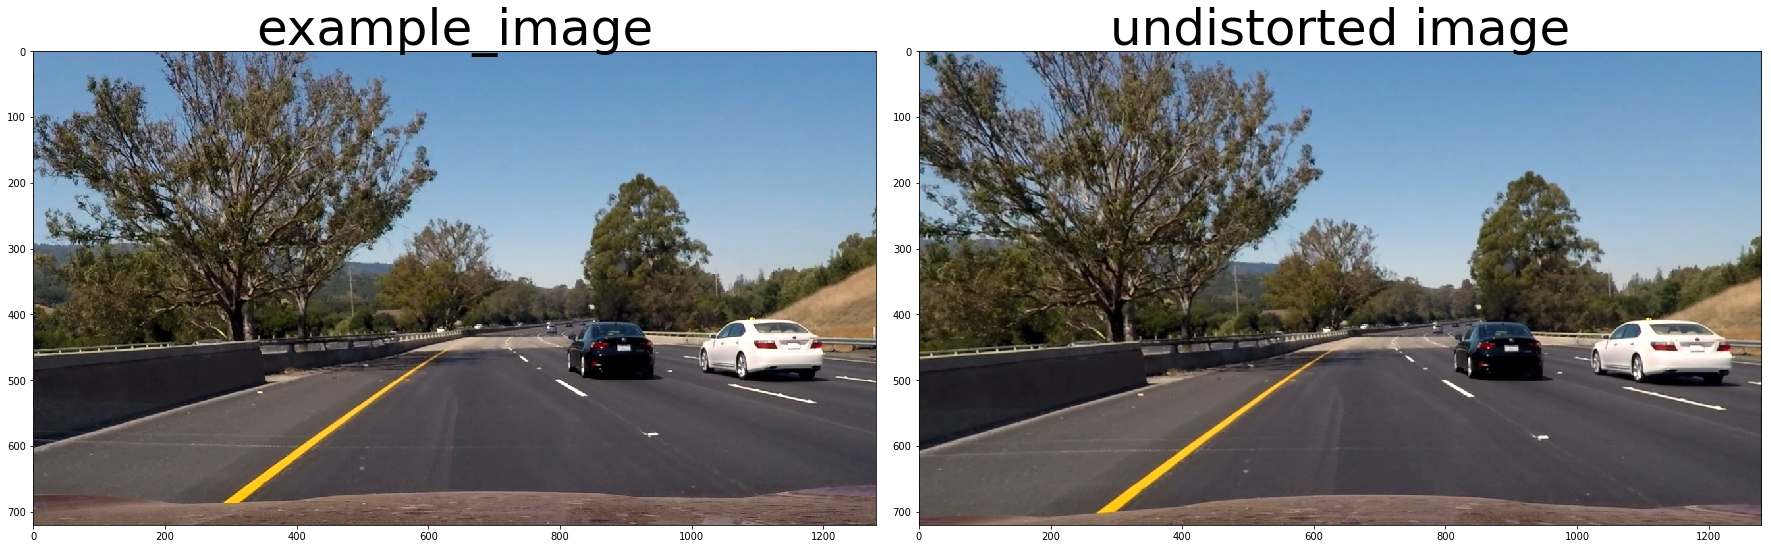

In [7]:
#example to show
#undistort image
eg_img = mpimg.imread("test_images/test6.jpg")
mtx, dist = get_mtx_dist()
eg_undistort = cv2.undistort(eg_img, mtx, dist, None, mtx)
#plt.imshow(eg_undistort)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(eg_img)
ax1.set_title('example_image', fontsize = 50)
ax2.imshow(eg_undistort)
ax2.set_title('undistorted image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

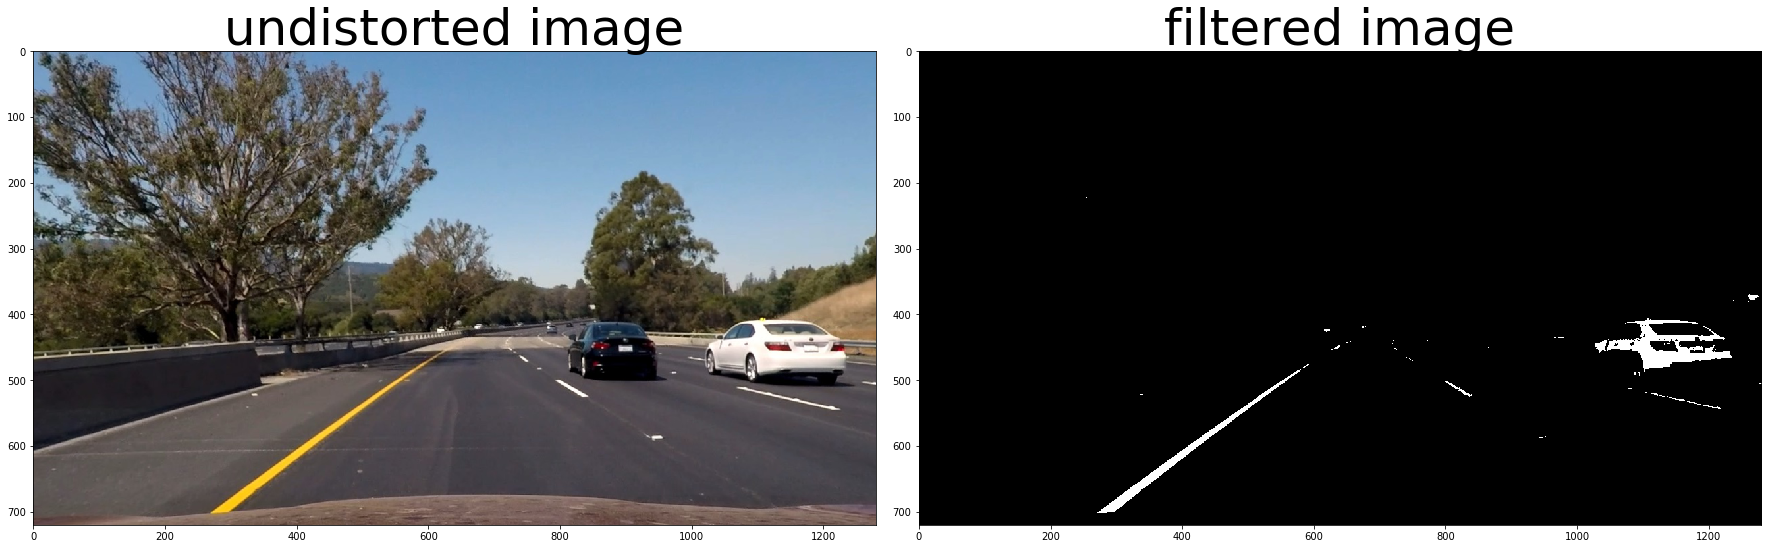

In [8]:
# thresholds for lane lines

eg_gradx = abs_sobel_thresh(eg_undistort, orient='x', thresh=(40,180))
#eg_grady = abs_sobel_thresh(eg_undistort, orient='y', thresh=(90,220))
#eg_hls_s = hls_s_select(eg_undistort, thresh=(200,250))
#eg_hls_l = hls_l_select(eg_undistort, thresh=(230,250))
eg_dir = dir_threshold(eg_undistort, thresh=(np.pi/6, np.pi/2))
#eg_combined = np.zeros_like(eg_hls_s)
#eg_combined[((eg_gradx==1) & (eg_grady==1))|(eg_hls_l==1)|(eg_hls_s==1)] = 1
eg_hls_s = hls_s_select(eg_undistort, thresh=(100, 255))
eg_hls_l = hls_l_select(eg_undistort, thresh=(120, 255))
eg_rgb_rg = r_g_select(eg_undistort, thresh =(150,255))
eg_luv_l = luv_l_select(eg_undistort, thresh = (205,255))
eg_lab_b = lab_b_select(eg_undistort, thresh = (155, 200))
eg_combined = np.zeros_like(eg_hls_s)
eg_combined[(((eg_gradx ==1) & (eg_dir==1)&(eg_lab_b==1)) | (eg_hls_s==1))& ((eg_rgb_rg==1) & (eg_hls_l==1))&((eg_luv_l==1))] = 1
#plt.imshow(eg_combined, cmap='gray')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(eg_undistort)
ax1.set_title('undistorted image', fontsize = 50)
ax2.imshow(eg_combined, cmap='gray')
ax2.set_title('filtered image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

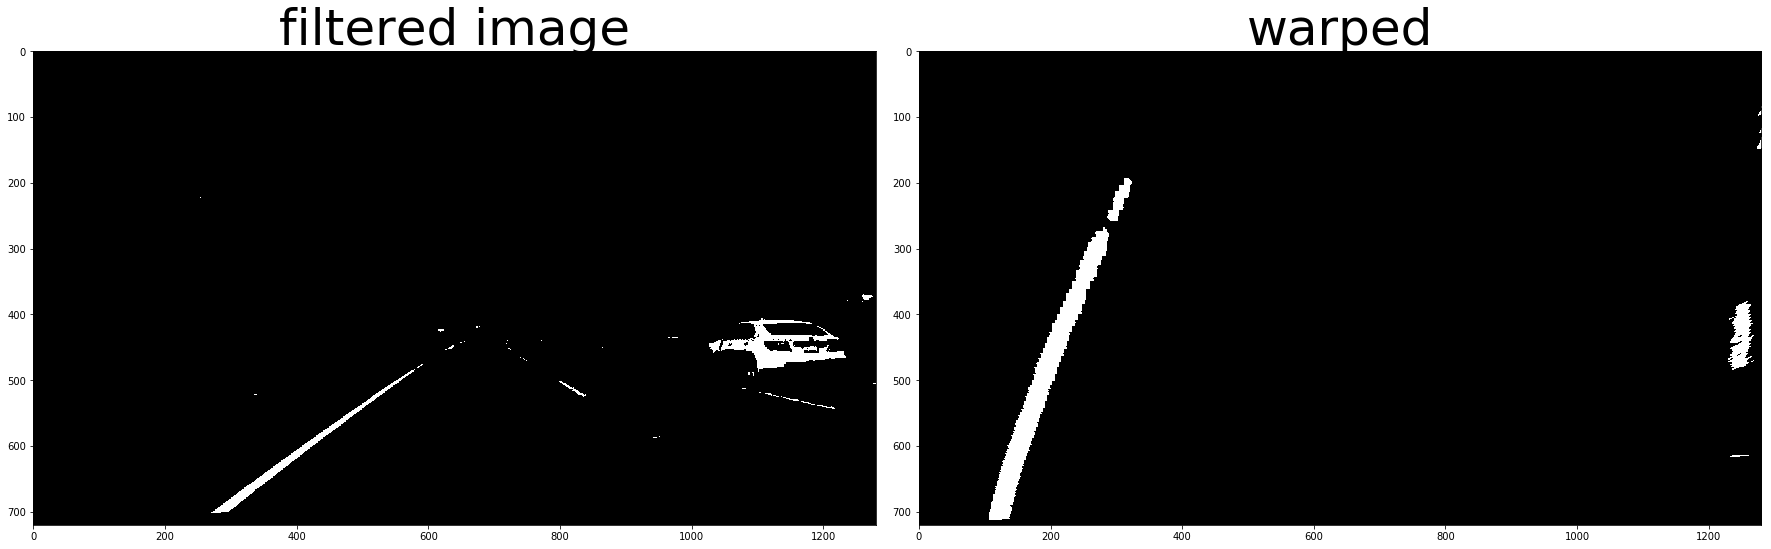

In [9]:
#perspective transform

eg_src_ini = np.float32([[560,460],[160,720],[1210,720],[730,460]])
eg_warped, eg_M, eg_Minv = perspective_transform_and_warp(eg_combined, eg_src_ini)
#print(eg_combined.shape)
#plt.imshow(eg_warped, cmap='gray')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(eg_combined, cmap = 'gray')
ax1.set_title('filtered image', fontsize = 50)
ax2.imshow(eg_warped, cmap='gray')
ax2.set_title('warped', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    


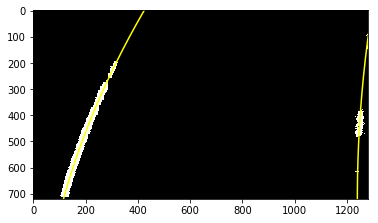

In [10]:
#find lane pixels and fit lines

eg_left_fit, eg_right_fit, eg_left_x_pred, eg_right_x_pred = find_lane_pixels(eg_warped)
eg_ploty = np.linspace(0, eg_warped.shape[0]-1, eg_warped.shape[0])

    ## Visualization ##
    # Plots the left and right polynomials on the lane lines
eg_out_img = np.dstack((eg_warped, eg_warped, eg_warped))*255
plt.plot(eg_left_x_pred, eg_ploty, color='yellow')
plt.plot(eg_right_x_pred, eg_ploty, color='yellow')
plt.imshow(eg_out_img)

1161.29181945
-0.198966210581


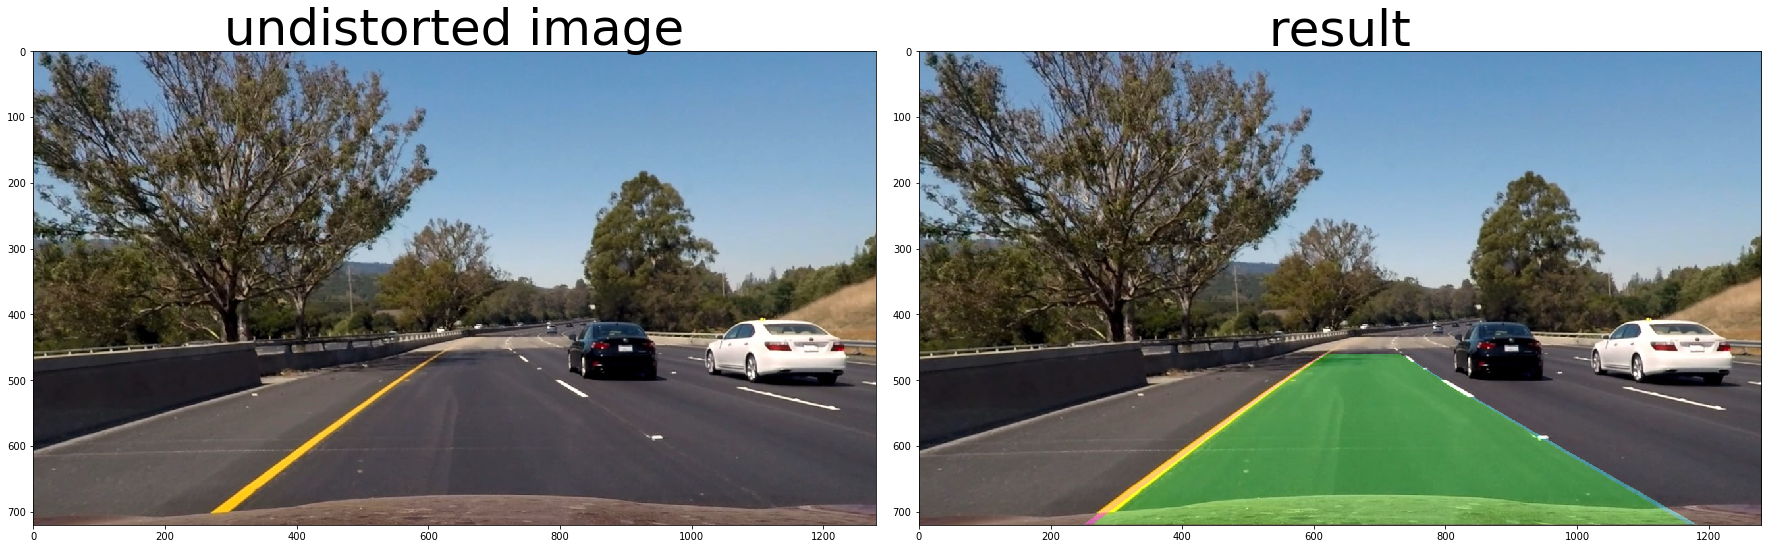

In [11]:
#calculate curvature and export result

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
eg_curverad = measure_curvature_real(eg_warped, eg_left_x_pred, eg_right_x_pred)
eg_center = (eg_right_x_pred[719] + eg_left_x_pred[719])/2
eg_offset = (eg_undistort.shape[1]/2 - eg_center)*xm_per_pix
eg_result = draw_lane(eg_undistort, eg_warped, eg_left_x_pred, eg_right_x_pred, eg_Minv)
print(eg_curverad)
print(eg_offset)
#plt.imshow(eg_result)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(eg_undistort, cmap = 'gray')
ax1.set_title('undistorted image', fontsize = 50)
ax2.imshow(eg_result, cmap='gray')
ax2.set_title('result', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

## pipeline for all test images

In [12]:
#pipeline for images
def pipeline_for_image(img):
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    gradx = abs_sobel_thresh(undistort, orient='x', thresh=(40,180))
    #eg_grady = abs_sobel_thresh(eg_undistort, orient='y', thresh=(90,220))
    #eg_hls_s = hls_s_select(eg_undistort, thresh=(200,250))
    #eg_hls_l = hls_l_select(eg_undistort, thresh=(230,250))
    dir_ = dir_threshold(undistort, thresh=(np.pi/6, np.pi/2))
    #eg_combined = np.zeros_like(eg_hls_s)
    #eg_combined[((eg_gradx==1) & (eg_grady==1))|(eg_hls_l==1)|(eg_hls_s==1)] = 1
    hls_s = hls_s_select(undistort, thresh=(100, 255))
    hls_l = hls_l_select(undistort, thresh=(120, 255))
    rgb_rg = r_g_select(undistort, thresh =(150,255))
    luv_l = luv_l_select(undistort, thresh = (205,255))
    lab_b = lab_b_select(undistort, thresh = (155, 200))
    combined = np.zeros_like(hls_s)
    combined[(((gradx ==1) & (dir_==1)&(lab_b==1)) | (hls_s==1))& ((rgb_rg==1) & (hls_l==1))&(luv_l==1)] = 1
    
    src_ini = np.float32([[560,460],[160,720],[1210,720],[730,460]])
    
    warped, M, Minv = perspective_transform_and_warp(combined, src_ini)
    
    
    
    left_fit, right_fit, left_x_pred, right_x_pred = find_lane_pixels(warped)
    
    curverad = measure_curvature_real(warped, left_x_pred, right_x_pred)
#eg_center = (eg_right_x_pred[719] + eg_left_x_pred[719])/2
#eg_offset = (eg_undistort.shape[1]/2 - eg_center)*xm_per_pix    
    xm_per_pix = 3.7/700
    center = (right_x_pred[719] + left_x_pred[719])/2
    offset = (undistort.shape[1]/2 - center)*xm_per_pix
    
    result = draw_lane(undistort, warped, left_x_pred, right_x_pred, Minv)
    

    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(result, 'curvature: {:.1f} m'.format(curverad), (50, 50), font, fontScale, fontColor, 2)
    if offset>= 0:
        cv2.putText(result,'vehicle is {:.2f} m left of center'.format(offset), (50, 200), font, fontScale, fontColor, 2)
    else:
        cv2.putText(result,'vehicle is {:.2f} m right of center'.format(-offset), (50, 200), font, fontScale, fontColor, 2)
    
   
    
    return result



#test_image processing
#test_image = os.listdir("test_images/")

mtx,dist = get_mtx_dist()

for test_image in os.listdir("test_images/"):

    image = mpimg.imread('test_images/'+test_image)

    result = pipeline_for_image(image)

#    plt.imshow(result)

    output_result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join("output_images/", 'output_'+test_image), output_result)

## use similar pipeline for video processing

In [148]:
from moviepy.editor import VideoFileClip

## get lines from frames to smooth

In [149]:

def get_lines(previous_lines, new_line):
    num_frames = 15
    
    if new_line is None:
        if len(previous_lines) ==0:
            return previous_lines, None
        else:
            return previous_lines, previous_line[-1]
    else:
        if len(previous_lines) < num_frames:
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line =np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line


## pipeline for video processing
implement  search_around_poly function to get lines from previous frames

In [150]:
        
def pipeline_for_video(img):
    global left_fit
    global right_fit
    global past_right_lines
    global past_left_lines
    global diff_lines
    global running_diff
    global left_x_pred
    global right_x_pred
    global curverad
    global out_img
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    gradx = abs_sobel_thresh(undistort, orient='x', thresh=(40,180))

#    grady = abs_sobel_thresh(undistort, orient='y', thresh=(90,220))

#    mg = mag_thresh(undistort, sobel_kernel=5, mag_thresh=(80, 120))

    dir_ = dir_threshold(undistort, thresh=(np.pi/6, np.pi/2))
    

    hls_s = hls_s_select(undistort, thresh=(100, 255))
    hls_l = hls_l_select(undistort, thresh=(120, 250))
    rgb_rg = r_g_select(undistort, thresh =(150,255))
    luv_l = luv_l_select(undistort, thresh = (205,255))
    lab_b = lab_b_select(undistort, thresh = (155, 200))
    combined = np.zeros_like(eg_hls_s)
    combined[(((gradx ==1) & (dir_==1)&(lab_b==1)) | (hls_s==1))& ((rgb_rg==1) & (hls_l==1))] = 1

#eg_combined[(((eg_gradx ==1) & (eg_dir==1)) | (eg_hls_s==1))& ((eg_rgb_rg==1) & (eg_hls_l==1))] = 1    
    src_ini = np.float32([[560,460],[160,720],[1210,720],[730,460]])

    warped, M, Minv = perspective_transform_and_warp(combined, src_ini)
    
    if (left_fit is None) or (right_fit is None):
                no_find = True
                left_fit, right_fit, left_x_pred, right_x_pred = find_lane_pixels(warped)
    else:
                no_find = False
                left_fit, right_fit, left_x_pred, right_x_pred = search_around_poly(warped, left_fit, right_fit)
                
    bad_find = False
    
    if (left_x_pred is None) or (right_x_pred is None):
                if no_find==True:
                        left_fit, right_fit, left_x_pred, right_x_pred = find_lane_pixels(warped)
                        

    
    if (left_x_pred is None) or (right_x_pred is None):
                
                bad_find = True
    else:
                diff_lines = np.mean(right_x_pred-left_x_pred)
                if running_diff == 0:
                        running_diff = diff_lines
                else:
                        running_diff = 0.9*running_diff + 0.1*diff_lines
                h = warped.shape[0]
                left_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
                right_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
                x_int_diff = abs(right_x_int-left_x_int)
                if (x_int_diff<1000) or (running_diff <0.9*diff_lines) or (running_diff > 1.1*diff_lines):
                    bad_find = True
                    if no_find == True:
                        left_fit, right_fit, left_x_pred, right_x_pred = find_lane_pixels(warped)
                        if (x_int_diff<1000) or (running_diff <0.9*diff_lines) or (running_diff > 1.1*diff_lines):
                            bad_find = True
                        else:
                            bad_find = False
                else:
                    bad_find = False
    if bad_find:
                left_fit = None
                right_fit = None
                if len(past_left_lines)==0 and len(past_right_lines) ==0:
                        return img
                else:
                        left_x_pred = past_left_lines[-1]
                        right_x_pred = past_right_lines[-1]
    else:
                past_left_lines, left_x_pred = get_lines(past_left_lines, left_x_pred)
                past_right_lines, right_x_pred = get_lines(past_right_lines, right_x_pred)
                diff_lines = np.mean(right_x_pred-left_x_pred)
                running_diff = 0.9*running_diff + 0.1*diff_lines
                left_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
                right_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
                x_int_diff = abs(right_x_int-left_x_int)
    
    curverad = measure_curvature_real(warped, left_x_pred, right_x_pred)
    xm_per_pix = 3.7/700
    center = (right_x_pred[719] + left_x_pred[719])/2
    offset = (undistort.shape[1]/2 - center)*xm_per_pix
    

    out_img = draw_lane(undistort, warped, left_x_pred, right_x_pred, Minv)


    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(out_img, 'curvature: {:.0f} m'.format(curverad), (50, 50), font, fontScale, fontColor, 2)
    if offset>= 0:
              cv2.putText(out_img,'vehicle is {:.2f} m left of center'.format(offset), (50, 200), font, fontScale, fontColor, 2)
    else:
              cv2.putText(out_img,'vehicle is {:.2f} m right of center'.format(-offset), (50, 200), font, fontScale, fontColor, 2)
    
    return out_img


## project video processing
it works pretty well!

In [151]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
running_diff = 0

project_video_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
project_video_clip = clip1.fl_image(pipeline_for_video)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [06:41<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 25s, sys: 3.38 s, total: 4min 29s
Wall time: 6min 44s


## challenge video 1
it works still well

In [152]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
running_diff = 0

challenge_video_output = 'output_videos/challenge_video.mp4'
clip2 = VideoFileClip("./challenge_video.mp4")

challenge_video_clip = clip2.fl_image(pipeline_for_video)
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [02:32<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 44s, sys: 1.17 s, total: 1min 46s
Wall time: 2min 35s


## harder challenge video
it doesn't work :( 
all thresholds and parameter need to be tuned in the extreme situation.

In [ ]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
running_diff = 0
harder_challenge_video_output = 'output_videos/harder_challenge_video.mp4'
clip3 = VideoFileClip("./harder_challenge_video.mp4")
harder_challenge_video_clip = clip3.fl_image(pipeline_for_video).subclip(0,1)
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)